Mahalanobis distance 1.52 in  S12


AttributeError: 'ROOT.MethodProxy' object has no attribute 'stateVector'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_survey
Info in <TCanvas::Print>: png file Survey.png has been created


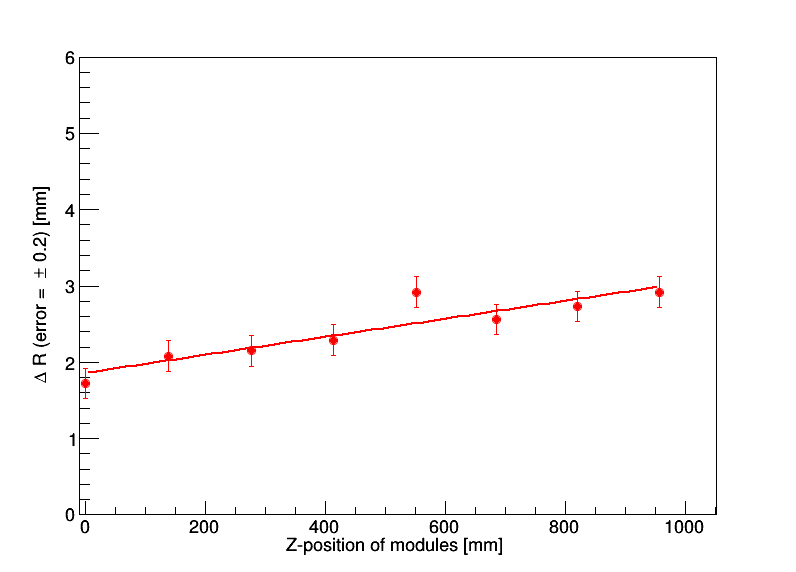

In [12]:
import sys, os 
import numpy as np
from array import array
import math
sys.path.append("/usr/local/Cellar/root/6.14.04_2/lib/root") # add ROOTv6 
from ROOT import TFile, TStyle, TCanvas, gStyle, TF1, TPaveStats, gPad, TGraphErrors, TLegend, TMatrixD, TDecompChol, TMath, TVectorD
from decimal import *
import scipy.stats as stat
round_to = 3 
getcontext().prec = round_to

#Define constants 
stationN=2
moduleN=8
parN = 2 #slope, intercept (b, c)
labels=("S12", "S18")
colors=(2, 4) # red, blue 
markerStyle=8 # dot 

#Define survey meas. 
Z = np.array([0.0, 138.4261909, 275.7030146, 412.8463143, 551.9417241, 684.9748242, 820.6609492, 956.1864672])
errX = np.zeros(moduleN)
measuredR_s12 = np.array([1.72, 2.08, 2.15, 2.29, 2.92, 2.56, 2.73, 2.92])
measuredR_s18 = np.array([3.05, 3.43, 3.81, 4.06, 4.46, 4.75, 5.05, 5.38])
measuredR = (measuredR_s12, measuredR_s18)
erR = 0.2 # 200 um / 0.2 mmm 
errR = np.ones(moduleN)*erR 

# Fit function is a 
line = "[0]*x + [1]" # bx + bc

#Make new canvas and legend with plotting range 
canvas_survey = TCanvas("canvas_survey", "", 800, 600)
legend = TLegend(0.4, 0.11, 0.89, 0.25)
rmin, rmax, zmin, zmax = 0.0, 6.0, -350.0, 1050.0

tge_array=[] # keep all graphs in scope 
fit_array=[]
for i_station in range(0, stationN):
    #Plot data 
    tge = TGraphErrors(moduleN, Z, measuredR[i_station], errX, errR)
    tge_array.append(tge)
    tge.SetTitle("; Z-position of modules [mm]; #Delta R (error = #pm 0.2) [mm]")
    tge.GetXaxis().CenterTitle()
    tge.GetYaxis().CenterTitle()
    tge.GetYaxis().SetRangeUser(rmin, rmax)
    tge.GetXaxis().SetRangeUser(zmin, zmax)
    tge.SetLineColor(colors[i_station])
    tge.SetMarkerColor(colors[i_station])
    tge.SetMarkerStyle(markerStyle)
    if(i_station==0):
        tge.Draw("AP")
    else:
        tge.Draw("P same")
    
    #Fit data 
    function_name = "tf_"+str(i_station)
    tf = TF1(function_name, line, Z[0], Z[-1]) # line fit in Z range 
    fit_result = tge.Fit(function_name, "QRS"); # Quite Chi2 fit over Range of the function, with pointer return (S)
    fit_array.append(fit_result)
    tge.GetFunction(function_name).SetLineColor(colors[i_station])
    slope = tge.GetFunction(function_name).GetParameter(0)
    slope_error = tge.GetFunction(function_name).GetParError(0)
    angle_deg = math.degrees(np.arctan(slope))
    angle_deg_error = math.degrees(slope_error)
    
    #Display fit results 
    legend.SetBorderSize(0)
    legend.AddEntry(tge, labels[i_station]+" #theta= "+str(Decimal(angle_deg)/Decimal(1))+" #pm "+str(Decimal(angle_deg_error)/Decimal(1)) , "l");

legend.Draw("SAME")
canvas_survey.Draw()
canvas_survey.Print("Survey.png")

# Mahalanobis fits 
col = [3, 7, 6, 7, 5, 2, 4, 1]

# Pick 1 sigma points per station 
for i_station in range(0, stationN):
    #Clear previous canvas
    canvas_survey.Clear()
    legend.Clear()
    
    #get parameter values 
    fitVals=[]
    for i_par in range(0, parN):
        fitVals.append(tge_array[i_station].GetFunction("tf_"+str(i_station)).GetParameter(i_par))

    # Covariance matrix
    covMatrix = fit_array[i_station].GetCovarianceMatrix()
    decompCholCov = TDecompChol(covMatrix)
    decompCholCov.Decompose()
    matrixCovI = decompCholCov.GetU()
    matrixCov=TMatrixD(parN, parN)
    matrixCov.Transpose(matrixCovI)
    
    #Calculate Mahalanobis distance for one sigma CL
    mu, sigma = 0, 1 # for a normal distribution (0, 1)
    prob = math.erf( (sigma-mu) / (sigma*math.sqrt(2)) ) #probability of being withing sigma from the mean 
    CL = 1-prob; # 1 - 68% (one sigma)
    r2 = 0 # r^2 (see https://upload.wikimedia.org/wikipedia/commons/a/a2/Cumulative_function_n_dimensional_Gaussians_12.2013.pdf)
    
    #compute the Mahalanobis distance for number for par 
    while (TMath.Prob(r2, parN) > CL):
        r2 += 0.00001
    r = math.sqrt(r2) # This is the Mahalanobis distance threshold under which CL % of points fall below
    print("Mahalanobis distance", Decimal(r)/Decimal(1), "in ", labels[i_station])
    
    #draw the nominal line
    tge_array[i_station].Draw("AP")
    
    stateN=0 # this is a counter, expect 9 states with 2 parametes 
    b, c = [], [] # contrainers to store slopes and intercepts 
    
    #loop over the 1sigma changes 
    for i_slope in range(-1, 2):
           for i_intercept in range(-1, 2):
                stateVector=TVectorD(i_slope, i_intercept)
               
                if(stateVector.Norm2Sqr() > 0):
                    scale =  r / math.sqrt(u.Norm2Sqr()) 
                else:
                    scale = 1
     
                # z = r*u*M + mean
               z = matrixCov * stateVector + fitVals
               
            
#                 for i_par in range(0, parN):
#                     print(z[i_par], " ")
        
    #save per station 
    legend.Draw("SAME")
    canvas_survey.Draw()
    canvas_survey.Print("Mach_line.png")
    
    
    







# 